# Ejemplo de un problema de clasificación con múltiples salidas

Una de las formas de solucionar la actividad de esta unidad (Captchas) requiere configurar un modelo de clasificación con 5 salidas. Una por cada símbolo en la imagen. Para este ejemplo, usaremos un conjunto de datos de imágenes, a partir de las cuales se debe predecir: la edad, el género y la Etnicidad.

## Etapa 1: Carga de los datos

In [1]:
import numpy as np

%matplotlib inline
from keras.utils import plot_model
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from keras import layers
from keras.models import Model
from keras.models import load_model
import pandas as pd
import cv2
import string
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

Se carga la base de datos, el archivo csv puede ser descargado desde: https://www.kaggle.com/datasets/nipunarora8/age-gender-and-ethnicity-face-data-csv?resource=download

La base de datos tiene 4 columnas: Age, Ethnicity y Gender corresponden a las salidas que se deben predecir. Por otro lado, pixels contiene la información de las imágenes.

In [2]:
!pip install jovian --upgrade --quiet
!pip install opendatasets --upgrade --quiet
import opendatasets as od
od.download('https://www.kaggle.com/datasets/nipunarora8/age-gender-and-ethnicity-face-data-csv?resource=download')

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.6/68.6 kB 1.6 MB/s eta 0:00:00
Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: hernanvargas1987
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/nipunarora8/age-gender-and-ethnicity-face-data-csv


100%|██████████| 63.2M/63.2M [00:00<00:00, 96.8MB/s]


In [3]:
D = pd.read_csv('/content/age-gender-and-ethnicity-face-data-csv/age_gender.csv')
#D = pd.read_csv('age_gender.csv')
D

,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...
...,...,...,...,...,...
23700,99,0,1,20170120221920654.jpg.chip.jpg,127 100 94 81 77 77 74 99 102 98 128 145 160 1...
23701,99,1,1,20170120134639935.jpg.chip.jpg,23 28 32 35 42 47 68 85 98 103 113 117 130 129...
23702,99,2,1,20170110182418864.jpg.chip.jpg,59 50 37 40 34 19 30 101 156 170 177 184 187 1...
23703,99,2,1,20170117195405372.jpg.chip.jpg,45 108 120 156 206 197 140 180 191 199 204 207...


In [4]:
D.pixels

,pixels
0,129 128 128 126 127 130 133 135 139 142 145 14...
1,164 74 111 168 169 171 175 182 184 188 193 199...
2,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,193 197 198 200 199 200 202 203 204 205 208 21...
4,202 205 209 210 209 209 210 211 212 214 218 21...
...,...
23700,127 100 94 81 77 77 74 99 102 98 128 145 160 1...
23701,23 28 32 35 42 47 68 85 98 103 113 117 130 129...
23702,59 50 37 40 34 19 30 101 156 170 177 184 187 1...
23703,45 108 120 156 206 197 140 180 191 199 204 207...


## Etapa 2: Procesamiento de las imágens y las etiquetas

In [5]:
# Las imágenes no están representadas adeucadamente. Esta parte del código adecua
# las imágenes.
Images = D.pixels.apply(lambda x: np.array(x.split(" "),dtype=float))
X = np.stack(Images)
X = X / 255.0
X = X.astype('float32')
X = X.reshape(X.shape[0], 48, 48, 1)

In [6]:
# Ahora tenemos 23705 imágenes en escala de grises de tamaño 48x48x1
X.shape

(23705, 48, 48, 1)

In [7]:
# Se extraen las etiquetas
# 1. Age: la salida Age toma valores enteros, si se asume como clasificación se
# configurarían muchas clases (una por cada edad). Para disminuir la cantidad de
# clases, se plantea una umbralización, por ejemplo, las edades entre 0 y 9 se
# asignan a la clase 0, las edades entre 10 y 15 en la clase 1 y así sucesivamente.
# De esta forma la salida age tiene 9 clases.
age_bins = [0,10,15,20,25,30,40,50,60,120]
age_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8]
D['age'] = pd.cut(D.age, bins=age_bins, labels=age_labels)
age =  np.expand_dims(np.array(D.age[:]), -1)
gender = np.expand_dims(np.array(D.gender[:]), -1)
eth = np.expand_dims(np.array(D.ethnicity[:]), -1)

print(len(np.unique(age))) #clases
print(len(np.unique(gender)))
print(len(np.unique(eth)))

# tener en cuenta este orden: primero age, que tiene 9 clases, segundo gender con
# dos clases y tercero eth con 5 clases.
Y = np.concatenate((age, gender, eth), axis=1)

9
2
5
0


In [8]:
# Se definen los conjuntos de entrenamiento y prueba.
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
h = X_train.shape[1]
w  = X_train.shape[2]
c = X_train.shape[3]
input_shape = (h, w, c)
print(input_shape) #tamaño de las imágenes
print(y_train[:,0])
print(y_test[:,0])

(48, 48, 1)
[4 0 1 ... 0 5 8]
[6 5 0 ... 3 5 5]


## 3. Definición del modelo

In [9]:
def createmodel():
    # se define una serie de capas convolucionales. Esta parte es igual al resto
    # de redes que se han usado
    img = layers.Input(shape=(input_shape))
    conv1 = layers.Conv2D(16, (3, 3), padding='same', activation='relu')(img)
    mp1 = layers.MaxPooling2D(padding='same')(conv1)
    conv2 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(mp1)
    mp2 = layers.MaxPooling2D(padding='same')(conv2)
    conv3 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(mp2)
    bn = layers.BatchNormalization()(conv3)
    mp3 = layers.MaxPooling2D(padding='same')(bn)

    flat = layers.Flatten()(mp3)

    # A partir de esta línea es donde empiezan los cambios. Tenemos 3 salidas.
    # La primera configura un problema con 9 clases, la segunda es una clasificación
    # binaria y la tercer una clasificación con 5 clases
    outs = [] # En esta lista se guardan las tres salidas. Las tres salidas se
    # aimentan de la salida de la capa flat.

    # Cada salida puede configurarse con diferents tipos de capas, a modo de ejemplo,
    # acá se utilizan estrucutras idénticas.

    # Salida 1: Clasificación con 9 clases.
    den_1 = layers.Dense(64, activation='relu')(flat)
    drop_1 = layers.Dropout(0.5)(den_1)
    # Changed 'Softmax' to 'softmax'
    sal_1 = layers.Dense(9, activation='softmax')(drop_1)
    outs.append(sal_1) #se añade el resultado a la lista

    # Salida 2: Clasificación binaria.
    den_2 = layers.Dense(64, activation='relu')(flat)
    drop_2 = layers.Dropout(0.5)(den_2)
    sal_2 = layers.Dense(1, activation='sigmoid')(drop_2)
    outs.append(sal_2) #se añade el resultado a la lista

    # Salida 3: Clasificación con 5 clases.
    den_3 = layers.Dense(64, activation='relu')(flat)
    drop_3 = layers.Dropout(0.5)(den_3)
    # Changed 'Softmax' to 'softmax'
    sal_3 = layers.Dense(5, activation='softmax')(drop_3)
    outs.append(sal_3) #se añade el resultado a la lista

    # Compile model and return it
    model = Model(img, outs) #create model
    # Se crea una lista de funciones Loss, una por cada salida. La primera y la
    # tercera son salidas de clasificación de múltiples clases, por lo tanto se
    # usa sparse_categorical_crossentropy, para la segunda función se usa la
    # binary_crossentropy
    Loss = ['sparse_categorical_crossentropy','binary_crossentropy','sparse_categorical_crossentropy']
    model.compile(loss=Loss, optimizer='adam',metrics=[['accuracy'], ['accuracy'], ['accuracy']])
    return model

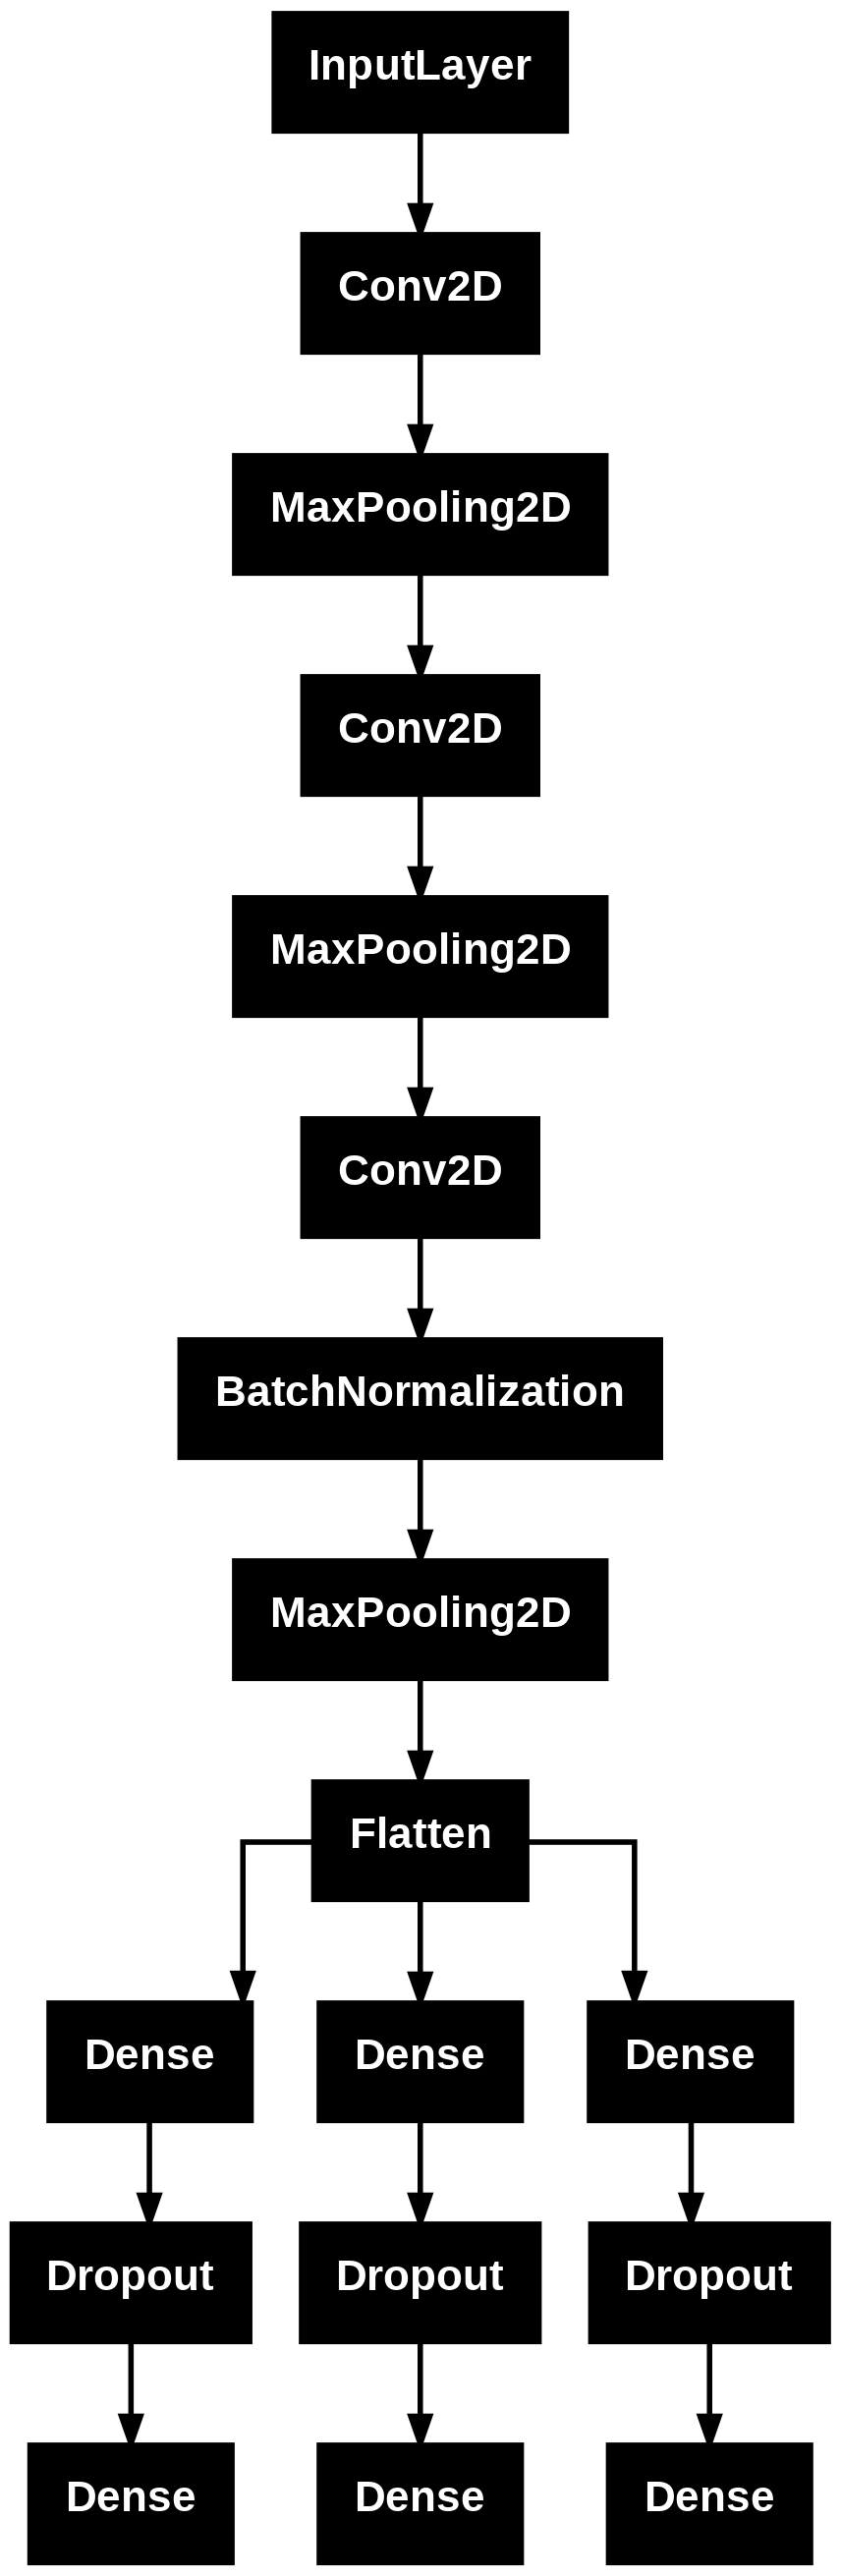

In [10]:
model = createmodel()
tf.keras.utils.plot_model(model)

In [11]:
hist = model.fit(X_train, [ y_train[:,0], # salida age
                           y_train[:,1], # salida gender
                           y_train[:,2] ]  # salida eth]
                           , batch_size=32, epochs=30,
                           validation_data=(X_test, [y_test[:,0],
                                                     y_test[:,1],
                                                     y_test[:,2]]))

Epoch 1/30
519/519 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - dense_1_accuracy: 0.2678 - dense_3_accuracy: 0.7055 - dense_5_accuracy: 0.4893 - loss: 3.8625 - val_dense_1_accuracy: 0.3919 - val_dense_3_accuracy: 0.7863 - val_dense_5_accuracy: 0.6019 - val_loss: 3.2749
Epoch 2/30
519/519 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - dense_1_accuracy: 0.3946 - dense_3_accuracy: 0.8395 - dense_5_accuracy: 0.6585 - loss: 2.8938 - val_dense_1_accuracy: 0.3990 - val_dense_3_accuracy: 0.8428 - val_dense_5_accuracy: 0.7016 - val_loss: 2.7039
Epoch 3/30
519/519 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - dense_1_accuracy: 0.4275 - dense_3_accuracy: 0.8646 - dense_5_accuracy: 0.7009 - loss: 2.6166 - val_dense_1_accuracy: 0.4494 - val_dense_3_accuracy: 0.8729 - val_dense_5_accuracy: 0.7388 - val_loss: 2.4243
Epoch 4/30
519/519 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - dense_1_accuracy: 0.4458 - dense_3_accuracy: 0.8762 - dense_5_accuracy: 0.7204 - loss: 2.4760 - val_dense_1_accuracy: 0.4339 - val_dense_3_accuracy: 0.8792 - val_de

In [14]:
preds = model.evaluate(X_test,[y_test[:,0], y_test[:,1],y_test[:,2]])
print('Acc_1:', preds[1])
print('Acc_2:', preds[2])
print('Acc_3:', preds[3])

223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - dense_1_accuracy: 0.4625 - dense_3_accuracy: 0.8899 - dense_5_accuracy: 0.7525 - loss: 2.6779
Acc_1: 0.460067480802536
Acc_2: 0.887514054775238
Acc_3: 0.7549212574958801
